In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
assert os.path.basename(os.getcwd()) == "element-electrode-localization", (
    "Please move to the " + "element directory"
)

In [2]:
import datajoint as dj
from pathlib import Path
import yaml

In [5]:
from tutorial_pipeline import lab, subject, session, probe, electrode_localization


[2024-01-17 01:49:49,381][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


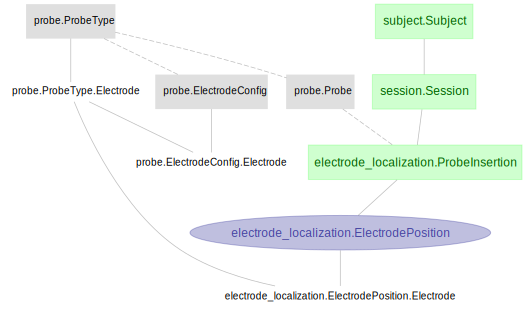

In [8]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(probe)
    + dj.Diagram(electrode_localization)
)